# Prediction of the most effective treatment for patients with breast cancer

This repository is the fruit of the collaborative work of **Eloi Ancellin**, **Maxime Bouthors**, **Joël Garde**, **Mathieu Juttet**, and **Louis-Oscar Morel**.
It was created as an assignement of the Data Camp course of the Master 2 Data Science of the Polytechnic Institute of Paris during the year 2021.

## Breast Cancer ; An introduction

Breast cancer is the most common cancer in women with 2 million new cases annually worldwide according to the WHO. It alone is responsible for more than 500,000 deaths per year and nearly one in seven women will develop this disease in her lifetime. Breast cancer is detected by mammography, but it is the pathological examination of the tissues taken from the patient that makes it possible to establish the precise diagnosis of breast cancer.

Pathology analysis is a complex process, **the challenge of which is to be able to offer the best treatment to each patient, thereby improving her chances of survival**. Therefore, the pathologist's role is to characterize the tumor so that the oncologist can give the best medicine. The diagnosis is based on the microscopic analysis of the lesion. 

The characterization of the tumor is based on (i) the analysis of its morphology which makes it possible to define its histological type (more than 25 types) and on (ii) its molecular characteristics.

The morphological analysis corresponds to the traditional anatomopathological examination, based on the analysis of cell types, their relationships, and whether or not the overall architecture of the tissue is respected.

Molecular analysis refine the type of tumor. Indeed, the development of therapies specifically targeting certain tumor molecular alterations present only in subgroups of patients, currently allows an increasingly important personalization of cancer treatment. The detection of these molecular abnormalities relies on the quantification of specific proteins in tumor tissue (Immunohistochemistry), the fluorescence quantification of specific genetic elements in tumor cells (FISH), the identification of tumor genomic abnormalities by sequencing of the DNA (NGS) [1 to 8]. Taking these characteristics into account when choosing the therapeutic approach has shown strong impacts on reducing the risk of disease progression (eg 35% for the treatment of metastatic breast cancer with Alpelisib, a molecule prescribed for female patients presenting RH + cancers (immunohistochemical characterization) with the presence of activating genomic mutations of the PIK3CA gene (NGS characterization)).

**It is the tumor precise characterization that makes it possible to better understand the biology of a given patient's cancer and thus to prescribe the most suitable treatment.**


However,**the complexity and number of examinations to perform for the precise characterization of the tumor increases the risk of errors.** For example, the proposal for innovative targeted chemotherapies is based on the combined interpretation by the physician of (i) morphological examination, HE biopsy, (ii) of the Extended Evaluation, (iii) of immunohistochemistry, (iv) of genomic analysis by DNA sequencing. The use of more and more parameters tends to make the diagnosis impracticable by the physician alone.

The development of statistical learning algorithms and Data Science has opened up opportunities for improvement in this field, but are still very limited. Indeed, these developments require access to data that are difficult to obtain, are based on complex interdisciplinary know-how (mathematics, medicine and Computer Science). Recent advances in AI are promising, but operate in a black box, thus slowing the adoption of these solutions by pathologists in the medical community.

### Conclusion:

The complexity of tumor diagnosis requires the development of new solutions allowing the automatic integration of multiparametric morphological and molecular analyzes allowing physician support in their diagnostic process, thus improving their analytical capacities and their ability to offer effective personalized treatments.



## Molecular Biology ; Key concepts to understand the work that needs to be done

**The aim of this project is to find profiles of patients with characteristics associated with a good or bad response to a specific treatment. Depending on the data we have, our goal will be to assign the right treatment for each patient, thus improving their chances of survival.**

The biology of cancer is complex. In this challenge, we will focus on (i) clinical data, such as age, ethnicity etc ...; (ii) the anatomopathological characteristics, ie the grade of the lesion, its stage and its histological type and; (iii) molecular biology, respectively genomic alteration (DNA mutation) and genomic expression (RNAseq) data.


The proposal for highly personalized treatments must take into account this very large amount of information. We will approach here very quickly the fundamental notions of biology so that the reader can understand the data and can work on the dataframe to reduce its dimensions and create relevant composite criteria for his prediction work.


DNA, or deoxyribonucleic acid, is a series of four chemical units called nucleotides (A, T, C, G), the combination of which supports information from living things. In humans, this “hardware” support is located in the nuclei of cells and represents a combination of 3 billion nucleotides grouped together in 23 pairs of chromosomes. The majority of this DNA (70%) is said to be non-coding, ie it does not allow the production of protein. The remaining 30% is divided into 20k-30k pairs of genes. A gene is a portion of DNA that produces messenger RNA (mRNA).


RNA is a sequence of nucleotides (A, U, C, G) which is copied from the DNA model by an enzyme (protein) during the process of "transcription". This mRNA leaves the nucleus of the cell to be then "translated" into protein by a ribosome (RNA/proteic complex). The ribosome matches each RNA nucleotide triplet with an amino acid. The sequence of these amino acids constitutes a protein. Proteins have chemical groups that allow them to influence their environment and are therefore one of the supports of life.


Cancer is characterized by an accumulation of mutations in DNA, causing changes in the function of proteins and therefore in the behavior of cells, making them:
- self-sufficient in growth signals;
- Insensitive to growth inhibiting signals;
- Capable of avoiding apoptosis (cell immortality);
- Capable of replicating indefinitely (infinite growth)
- Capable of inducing angiogenesis and forming metastases.



# Getting started
The starting kit notebook can be found [here](https://github.com/MathieuJuttet/Cancer/blob/main/Starting_kit.ipynb). It provides detailed information on the project and explanations on the data.





## Data Loading and Processing

Collecting large and complete data for tumor characterization is a complex task. We have chosen to base ourselves on the GDC Portal, which aggregates many databases specializing in cancer. The GDC Data Portal is a robust data-driven platform that allows cancer researchers and bioinformaticians to search and download cancer data for analysis.

The GDC Data Portal combines 67 projects focusing on 68 different cancers for a total of 84,392 patients. We were interested in patients with primary breast cancer (9,115 cases). Data retrieval for these 9115 patients was achieved by sending a JSON through the GDC API.
(insert code).

expliquer le travail qui a été fait sur la récuperation des données, son organisation, pourquoi on a viré certaines colonnes etc...
(insert code)


In order to get data, we used the API provided by the GDC website. From this load, we get 4 datasets that we load in separate dataframes. First, we will show how we performed the API query, then how we have cleaned them up to get a single dataframe. 


In [1]:
import requests
import json
import pandas as pd
import numpy as np
import os.path

In [2]:
##### Folders
pload_p = "payload/"
data_p = "data/"

headers = {'Content-Type': 'application/json',}
root = 'https://api.gdc.cancer.gov/'
endpt_l = {"case":"cases",
           "ssm":"ssm_occurrences",
           "cnv":"cnv_occurrences",
           "gene":"analysis/top_mutated_genes_by_project"}

pload_l = ["case", "ssm", "cnv", "gene"]

def dl(endpt, data):
    """ simple wrapper around request.post with correct arguments filled in.
    """
    response = requests.post(root + endpt, timeout=30, headers=headers, data=data)
    return response.text

In [3]:
def fill_filter_gene():
    """ Builds the filter for cvn/ssm to ensure only motation on top genes are reported.
    """
    top_genes = pd.read_csv(data_p + "gene.tsv", "\t")["symbol"].to_numpy()
    for req in ("ssm", "cnv"):
        with open(pload_p + req, "r+") as f:
            payload = json.load(f)
            payload["filters"]["content"][0]["content"]["value"] = list(top_genes)
            f.seek(0)
            json.dump(payload, f, separators=(",",":"))
            f.truncate()

In [4]:
def load(fname, force_dl=False):
    """ wrapper utility to avoid re-downloading data.
    """
    fp = data_p + fname + ".tsv"
    if not force_dl and os.path.exists(fp):
        return pd.read_csv(fp, sep="\t", low_memory=False)
    #load request params
    print(f"file {fp} not found... Downloading...")
    data = open(pload_p + fname)
    text = dl(endpt_l[fname], data)
    with open(fp, "w") as f:
        f.write(text)
        
    return pd.read_csv(fp, sep="\t", low_memory=False)       

In [5]:
casedf = load("case")
genedf = load("gene")
fill_filter_gene() #update filters to only cater top 50genes
ssmdf = load("ssm")
cnvdf = load("cnv")

After executing the above code, you have four .tsv files in a data folder.
Now, we will load the downloaded data cleaning we have done.

In [6]:
import pandas as pd
import numpy as np 

In [7]:
df_case = pd.read_csv('data/case.tsv', sep='\t')
df_cnv = pd.read_csv('data/cnv.tsv', sep='\t')
df_gene = pd.read_csv('data/gene.tsv', sep='\t')
df_ssm = pd.read_csv('data/ssm.tsv', sep='\t')

/Users/macbookprodeloi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,25,28,29,51,53,54,55,56,57,60,61,62,87,97,119,139,140,148,151,154,156,157,161,162,163,165,166,168,171,175,176,177,185,186,187,189,190,192,199,200,201,209,210,211,213,214,216,219,223,224,225,233,234,235,237,238,239,241,242,243,244,245,246,247,248,249,251,258,259,260,268,269,270,272,273,275,282,283,284,292,293,294,296,297,299,302,306,307,316,317,318,320,321,323,326,330,331,340,342,344,345,347,353,354,355,364,365,366,368,369,371,374,378,379,388,389,390,392,393,410,416,419,428,429,437,440,441,444,446,448,449,450,452,455,467,470,472,473,488,491,492,503,506,508,509,510,511,514,515,519,523,524,527,528,539,542,544,545,546,547,550,551,555,559,560,563,564,575,578,580,581,582,583,586,587,591,595,596,599,600,611,614,616,618,619,622,623,627,631,632,635,636,647,654,655,658,659,663,667,668,672,683,690,691,694,695,699,703,

### Clinical and pathological Data

The clinical and pathological data is provided through the df_case dataframe. It contains general informations about the patient, age, sexe, ethnicity, multiple risk factors, diagnosis informations, what treatment has been given, the stage of the tumor, caracteristics of the tumor...etc

Below is the display of all the columns and their filling purcentage.


In [8]:
serie = df_case.notnull().mean()*100
for name,val in zip(serie.index,serie): 
    print(name,'\t',val)

annotations.0.annotation_id 	 0.31815688425671973
annotations.0.case_id 	 0.31815688425671973
annotations.0.category 	 0.31815688425671973
annotations.0.classification 	 0.31815688425671973
annotations.0.created_datetime 	 0.31815688425671973
annotations.0.entity_id 	 0.31815688425671973
annotations.0.entity_submitter_id 	 0.31815688425671973
annotations.0.entity_type 	 0.31815688425671973
annotations.0.notes 	 0.31815688425671973
annotations.0.state 	 0.31815688425671973
annotations.0.status 	 0.31815688425671973
annotations.0.submitter_id 	 0.31815688425671973
annotations.0.updated_datetime 	 0.31815688425671973
annotations.1.annotation_id 	 0.06582556226001096
annotations.1.case_id 	 0.06582556226001096
annotations.1.category 	 0.06582556226001096
annotations.1.classification 	 0.06582556226001096
annotations.1.created_datetime 	 0.06582556226001096
annotations.1.entity_id 	 0.06582556226001096
annotations.1.entity_submitter_id 	 0.06582556226001096
annotations.1.entity_type 	 0.065

samples.5.longest_dimension 	 0.0
samples.5.method_of_sample_procurement 	 0.0
samples.5.oct_embedded 	 0.0
samples.5.passage_count 	 0.0
samples.5.pathology_report_uuid 	 0.0
samples.5.preservation_method 	 0.0
samples.5.sample_id 	 0.15359297860669227
samples.5.sample_type 	 0.15359297860669227
samples.5.sample_type_id 	 0.0
samples.5.shortest_dimension 	 0.0
samples.5.state 	 0.15359297860669227
samples.5.submitter_id 	 0.15359297860669227
samples.5.time_between_clamping_and_freezing 	 0.0
samples.5.time_between_excision_and_freezing 	 0.0
samples.5.tissue_collection_type 	 0.0
samples.5.tissue_type 	 0.15359297860669227
samples.5.tumor_code 	 0.0
samples.5.tumor_code_id 	 0.0
samples.5.tumor_descriptor 	 0.0
samples.5.updated_datetime 	 0.15359297860669227
samples.6.biospecimen_anatomic_site 	 0.09873834339001646
samples.6.biospecimen_laterality 	 0.0
samples.6.catalog_reference 	 0.0
samples.6.composition 	 0.0
samples.6.created_datetime 	 0.09873834339001646
samples.6.current_wei

In [9]:
print(df_case.shape)

(9115, 782)


We observe two things: 
* There are 782 columns and a lot of them a not useful to tackle our problem
* There are many empty columns

Over those 782 columns, we have decided to eliminate many of them. 
First, many of them are empty or almost empty, thus, we set a threshold corresponding to 10% of fill rate. Below this trigger, the column will be dropped.
Moreover, some columns will resist but with no useful informations, such as the id's. Indeed, we are interested in having information about a certain patient, in one dataframe. Then, having the case_id, which is the id of the patient is enough to link all the dataframes together. Other columns are of no use for preduction such as the ones containing data on the tissue source site ( the hospital it has been taken from the patient), the sample state (which is to say if the data has been released of not)...etc. We also drop them.

In [10]:
df_case = df_case.drop(df_case.columns[df_case.notnull().mean()<0.1], axis=1)
columns_to_drop = ['tissue_source_site.code', 'tissue_source_site.project','tissue_source_site.name', 'diagnoses.0.treatments.1.state', 'diagnoses.0.state', 'diagnoses.0.treatments.0.state', 'exposures.0.state', 'samples.0.state', 'samples.1.state', 'samples.2.state', 'demographic.demographic_id', 'demographic.state', 'demographic.submitter_id', 'demographic.updated_datetime', 'diagnoses.0.diagnosis_id', 'diagnoses.0.icd_10_code', 'diagnoses.0.submitter_id', 'diagnoses.0.treatments.1.updated_datetime', 'diagnoses.0.treatments.1.submitter_id', 'diagnoses.0.treatments.0.updated_datetime', 'diagnoses.0.updated_datetime', 'exposures.0.exposure_id', 'exposures.0.submitter_id', 'exposures.0.updated_datetime', 'samples.0.created_datetime', 'samples.0.sample_id', 'samples.0.sample_type_id', 'samples.0.submitter_id', 'samples.0.updated_datetime', 'samples.1.sample_id', 'samples.1.sample_type_id', 'samples.1.submitter_id', 'samples.2.sample_id', 'samples.2.sample_type_id', 'samples.2.submitter_id', 'tissue_source_site.bcr_id', 'submitter_id', 'diagnoses.0.treatments.0.submitter_id', 'diagnoses.0.treatments.1.treatment_id', 'samples.2.updated_datetime', 'samples.1.updated_datetime', 'diagnoses.0.treatments.0.treatment_id', 'demographic.created_datetime', 'diagnoses.0.created_datetime', 'tissue_source_site.tissue_source_site_id']
df_case = df_case.drop(columns_to_drop, axis=1)
serie = df_case.notnull().mean()

In [11]:
df_case.head()

,case_id,demographic.age_at_index,demographic.days_to_birth,demographic.ethnicity,demographic.gender,demographic.race,demographic.vital_status,demographic.year_of_birth,diagnoses.0.age_at_diagnosis,diagnoses.0.ajcc_pathologic_m,...,samples.0.tissue_type,samples.0.tumor_descriptor,samples.1.is_ffpe,samples.1.oct_embedded,samples.1.sample_type,samples.1.tissue_type,samples.2.is_ffpe,samples.2.oct_embedded,samples.2.sample_type,samples.2.tissue_type
0,e479200e-a6dc-4973-b326-8ae7eab5bc88,NaN,NaN,not reported,female,not reported,Not Reported,NaN,26671.0,NaN,...,Not Reported,Primary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0532931f-a727-42d8-877f-3e4a20e2ee44,18993.0,-18993.0,not hispanic or latino,female,white,Not Reported,NaN,NaN,NaN,...,Not Reported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b30a070d-e090-40cc-8277-33fdc66a7700,27393.0,-27393.0,not hispanic or latino,female,white,Not Reported,NaN,NaN,NaN,...,Not Reported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,017a3a78-249c-48e0-a758-f48351ba5734,25567.0,-25567.0,not hispanic or latino,female,white,Not Reported,NaN,NaN,NaN,...,Not Reported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1a38613b-e8f8-4ac9-b86d-cae0738d6625,18262.0,-18262.0,not hispanic or latino,female,white,Not Reported,NaN,NaN,NaN,...,Not Reported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Molecular Biology Data

In the era of post-genomic living (Lander, E. et al. Initial sequencing and analysis of the human genome. Nature (2001)), our ability to sequence DNA and integrate numerous biological data allows us to develop increasingly personalized approaches to understanding and treating cancer. In this challenge, in combination with "traditional" criteria for characterizing cancer (ie: clinical and pathological data), we will also be interested in genetic data.

Nous allons nous interesser pour chaque patient aux 50 gènes les plus mutés dans cette population.

connus comme étant impliqués dans les cancers d’une façon générale (gènes les plus mutés dans la population tumorale). Pour chaque gène et pour chaque patient, nous allons essayer d’obtenir 3 informations :

The molecular data that interests us here are of two kinds:
- Genomic data: DNA mutations
- Transcriptomic data: number of mRNA copies that each gene produces.

#### Genomic data:

We will be interested in genetic mutations for the 50 most mutated genes in the population of patients with breast cancer.

There are two main types of mutations:
- "Copy Number Variation" (CNV) type mutations and "Single somatic Mutation" (SSM) type mutations.

CNVs are a variation in the copy number of a given gene. Indeed, a gene is a sequence of several thousand nucleotide base pairs. A CNV gain causes an increase in the number of copies of this gene, thus being able to produce more RNA transcripts and therefore potentially more proteins leading to a modification of the biology of the cell. A CNV loss will lead to a disappearance of the gene leading to a loss of the protein and therefore of its biological functionality.

SSMs are so-called ponctual mutations. The ponctual mutation will change one or a few nucleotides in the DNA sequence. This will change the copied RNA and the RNA-copying ribosome will not make the correct amino acid match. Thus, the protein will be modified and therefore its functionality as well.



In [12]:
columns_to_drop = ['cnv.cnv_id', 'id']
df_cnv.drop(columns_to_drop, axis=1, inplace=True)
df_cnv.notnull().mean()

case.case_id                        1.0
cnv.chromosome                      1.0
cnv.cnv_change                      1.0
cnv.consequence.0.consequence_id    1.0
cnv.consequence.0.gene.symbol       1.0
cnv.end_position                    1.0
cnv.gene_level_cn                   1.0
cnv.ncbi_build                      1.0
cnv.start_position                  1.0
cnv.variant_status                  1.0
dtype: float64

In [13]:
df_cnv.head()

,case.case_id,cnv.chromosome,cnv.cnv_change,cnv.consequence.0.consequence_id,cnv.consequence.0.gene.symbol,cnv.end_position,cnv.gene_level_cn,cnv.ncbi_build,cnv.start_position,cnv.variant_status
0,c5891c7a-fd24-4891-8f51-373967e4a6dd,17,Loss,99c68f83-9514-5628-9623-0ba6095dd90f,BCAS3,61392838,True,GRCh38,60677453,Tumor only
1,d5f2b85a-94a9-4168-bbe8-149ec71342b0,17,Gain,a7e6f054-f5a1-5e7f-a0c0-8daa7373a434,ABCA8,68955392,True,GRCh38,68867292,Tumor only
2,eafa45a4-2fd1-4fa3-860c-9d52ed382b7d,11,Gain,924c27ca-11cf-5b13-95b9-cf518abb142d,ORAOV1,69675416,True,GRCh38,69653076,Tumor only
3,dd0f8e5a-383d-4f03-bb71-0e115d4e442c,11,Gain,00461981-a326-573d-a9a1-ad82872a1aea,SHANK2,71252577,True,GRCh38,70467856,Tumor only
4,233b02f3-c4f0-4a67-9db5-e68d5cdaccb6,8,Gain,c6208422-2c76-553a-b0eb-4472e816381f,MYC,127741434,True,GRCh38,127735434,Tumor only


In [14]:
#Now let's look at the SSM dataframe

In [15]:
serie = df_ssm.notnull().mean()*100
for name,val in zip(serie.index,serie): 
    print(name,'\t',val)

case.case_id 	 100.0
id 	 100.0
ssm.chromosome 	 100.0
ssm.consequence.0.consequence_id 	 100.0
ssm.consequence.0.transcript.gene.symbol 	 100.0
ssm.consequence.1.consequence_id 	 91.22283766510438
ssm.consequence.1.transcript.gene.symbol 	 91.22283766510438
ssm.consequence.10.consequence_id 	 30.336599914784834
ssm.consequence.10.transcript.gene.symbol 	 30.336599914784834
ssm.consequence.11.consequence_id 	 29.825308904985086
ssm.consequence.11.transcript.gene.symbol 	 29.825308904985086
ssm.consequence.12.consequence_id 	 26.8001704303366
ssm.consequence.12.transcript.gene.symbol 	 26.8001704303366
ssm.consequence.13.consequence_id 	 26.54452492543673
ssm.consequence.13.transcript.gene.symbol 	 26.54452492543673
ssm.consequence.14.consequence_id 	 26.501917341286752
ssm.consequence.14.transcript.gene.symbol 	 26.501917341286752
ssm.consequence.15.consequence_id 	 26.41670217298679
ssm.consequence.15.transcript.gene.symbol 	 26.41670217298679
ssm.consequence.16.consequence_id 	 26.37

The consequence_id, as well as the cosmic_id are not useful at all. We delete them all.

In [16]:
df_ssm.drop(df_ssm.columns[df_ssm.columns.str.contains('ce_id')], axis=1, inplace=True)
df_ssm.drop(df_ssm.columns[df_ssm.columns.str.contains('[0-2][1-9]')], axis=1, inplace=True)
df_ssm.drop(df_ssm.columns[df_ssm.columns.str.contains('[1-9]')], axis=1, inplace=True)
columns_to_drop = ["ssm.cosmid_id.0","id"]
df_ssm.drop("id", axis=1,inplace=True)
df_ssm.head(5)

,case.case_id,ssm.chromosome,ssm.consequence.0.transcript.gene.symbol,ssm.cosmic_id.0,ssm.end_position,ssm.genomic_dna_change,ssm.mutation_subtype,ssm.mutation_type,ssm.ncbi_build,ssm.reference_allele,ssm.ssm_id,ssm.start_position,ssm.tumor_allele
0,d2694b09-7844-4496-865c-5d3d8cd03330,chr3,MUC4,NaN,195780168,chr3:g.195780168A>T,Single base substitution,Simple Somatic Mutation,GRCh38,A,92dded19-d0ce-5c34-9d99-169342f9bc37,195780168,T
1,17baef7c-d97d-4b98-ab53-503ef856523d,chr3,PIK3CA,COSM446001,179203764,chr3:g.179203764A>C,Single base substitution,Simple Somatic Mutation,GRCh38,A,7ea2ecba-9bbc-5d84-8a58-2ed20f13bdf3,179203764,C
2,d3d545b3-457f-4389-821f-704cb24aff7f,chr17,TP53,COSM1480087,7676042,chr17:g.7676041_7676042insGA,Small insertion,Simple Somatic Mutation,GRCh38,'-,1c4dad33-40cc-58d0-9d8c-4d808cb33401,7676041,GA
3,55262fcb-1b01-4480-b322-36570430c917,chr17,ABCA8,NaN,68883820,chr17:g.68883820C>G,Single base substitution,Simple Somatic Mutation,GRCh38,C,905a9d14-3a2e-5fb8-994e-48a2e5a1fa54,68883820,G
4,91b09291-5944-4691-a0d8-7d1ccc649b9b,chr3,MUC4,COSM3847118,195782578,chr3:g.195782578G>A,Single base substitution,Simple Somatic Mutation,GRCh38,G,eb5acb6d-ebcc-50fc-9dc0-9a7ac5b85fc4,195782578,A


### Transcriptomic data:

It is extremely relevant to add the so-called “transcriptomic” data to these genomic data. They correspond to the level of expression of the gene. The transcriptome represents the amount of mRNA produced for each gene. It is therefore interesting to look at this level of gene expression because it provides more direct information on the number of proteins and their types than analysis of DNA alone.

## Top 50 most mutated genes

Cancer are provoked by DNA mutations. Knowing what mutation has happened, on which gene is a valuable information to predict what cure shall be given. We chose to use the top 50 mutated genes in breast cancer. This choice is totally arbitrary and is done in order to limit the input dimension and conserve most of the data's value.

In [17]:
df_gene.head()

,_score,symbol
0,451.0,PIK3CA
1,404.0,TP53
2,322.0,MUC4
3,320.0,SHANK2
4,318.0,ANO1


## Whole dataframe

In [18]:
df = pd.read_csv('data/gdc_final_database.csv', sep=',')

In [19]:
df.head()

,Unnamed: 0,case_id,demographic.age_at_index,demographic.days_to_birth,demographic.ethnicity,demographic.gender,demographic.race,demographic.vital_status,demographic.year_of_birth,diagnoses.0.age_at_diagnosis,...,arn.HTseq_counts.TG,arn.HTseq_counts.TP53,arn.HTseq_counts.TPCN2,arn.HTseq_counts.TRPS1,arn.HTseq_counts.TTN,ssm.importance.AC108925.1,ssm.importance.FADD,ssm.importance.FGF19,ssm.importance.DNAJB6P5,arn.HTseq_counts.AC108925.1
0,0,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,50.0,-18345.0,not hispanic or latino,female,white,Alive,1955.0,18345.0,...,18.0,2997.0,655.0,8320.0,341.0,0.0,0.0,0.0,0.0,0.0
1,1,00a2d166-78c9-4687-a195-3d6315c27574,56.0,-20713.0,not hispanic or latino,female,white,Alive,1954.0,20713.0,...,19.0,6779.0,1123.0,13940.0,306.0,0.0,0.0,0.0,0.0,0.0
2,2,00b11ca8-8540-4a3d-b602-ec754b00230b,61.0,-22497.0,not hispanic or latino,female,white,Alive,1951.0,22497.0,...,56.0,4543.0,3168.0,15170.0,1334.0,0.0,0.0,0.0,0.0,0.0
3,3,011b9b2d-ebe5-42bf-9662-d922faccc7a1,71.0,-26274.0,not hispanic or latino,female,white,Alive,1939.0,26274.0,...,391.0,7822.0,1206.0,212884.0,19495.0,0.0,0.0,0.0,0.0,0.0
4,4,01263518-5f7c-49dc-8d7e-84b0c03a6a63,76.0,-27942.0,not reported,female,not reported,Alive,1933.0,27942.0,...,20.0,5374.0,2801.0,40581.0,244.0,0.0,0.0,0.0,0.0,0.0


In [20]:
serie = df.notnull().mean()*100
for name,val in zip(serie.index,serie): 
    print(name,'\t',val)

Unnamed: 0 	 100.0
case_id 	 100.0
demographic.age_at_index 	 79.62291515591008
demographic.days_to_birth 	 78.60768672951414
demographic.ethnicity 	 99.92748368382887
demographic.gender 	 99.92748368382887
demographic.race 	 99.92748368382887
demographic.vital_status 	 99.92748368382887
demographic.year_of_birth 	 79.4778825235678
diagnoses.0.age_at_diagnosis 	 96.44670050761421
diagnoses.0.ajcc_pathologic_m 	 79.62291515591008
diagnoses.0.ajcc_pathologic_n 	 79.62291515591008
diagnoses.0.ajcc_pathologic_stage 	 88.46990572878897
diagnoses.0.ajcc_pathologic_t 	 79.62291515591008
diagnoses.0.ajcc_staging_system_edition 	 69.39811457577954
diagnoses.0.classification_of_tumor 	 89.2675852066715
diagnoses.0.days_to_diagnosis 	 79.69543147208121
diagnoses.0.days_to_last_follow_up 	 72.08121827411168
diagnoses.0.last_known_disease_status 	 89.2675852066715
diagnoses.0.morphology 	 99.92748368382887
diagnoses.0.primary_diagnosis 	 99.92748368382887
diagnoses.0.prior_malignancy 	 88.542422044

In [21]:
df["diagnoses.0.ajcc_pathologic_m"].unique()

array(['M0', 'MX', 'M1', 'cM0 (i+)', nan], dtype=object)

One can wonder why there are so many columns. Since we have chosen to have the importance of the CNV and SSM for all 50 genes, it adds us automatically a hundred columns. The one hot-encoding rises the dimension of the problem.

## Merge of the dataframes

# Attendre notebook de maxime


## Limitation of this challenge:

The data has been simplified for easier analysis. There are many different types of genomic mutations, involving different biological changes. To simplify this aspect, we produced a relatively arbitrary intermediate score to quantify the importance of the mutations for each gene.

@Maxime: insert code with score and explanation of the choice of scoring.

There are more different RNAs than genes because the process of "alternative RNA splicing" adds a degree of freedom for a gene to encode several different proteins. We have considered here all the mRNAs of a gene as coming from a single transcript.

@Maxime: insert code and explanation.





# Exploratory Data Analysis

Pour que le challenger puisse naviguer dans ces données, nous avons préalablement collecté et formaté ces caractéristiques dans un dataframe de grande dimension (dim*dim). Pour plus d'informations sur l'obtention de ces données: voir la partie **Data loading**.

## Clinical 

Number of cases
Disease Type (histology)
  - number of each subtypes (can we split ductal and lobular ?)
  - Age at Diagnosis for each subtype → statistical difference for each type ? (p-value)
  - Survival for each disease type → statistical difference for each type ? (p-value)
  - General treatment for each subtype ? (Treatment Type in GDC) → normally we just have 1098 cases for which we have pharmaceutical therapy/radiation therapy
      Surgery ?
      Radiotherapie?
      Chemotherapy ?
      Which drugs are used ?


### How to get the subtype = df["diagnoses.0.primary_diagnosis"].unique() can they be grouped ? There are 34 of them

Treatment column : df["diagnoses.0.treatments.0.treatment_type"].unique() and   
df["diagnoses.0.treatments.1.treatment_type"].unique()
Vital status: df["demographic.vital_status"].unique()

In [22]:
df["diagnoses.0.treatments.0.treatment_type"].unique() 


array(['Pharmaceutical Therapy, NOS', 'Radiation Therapy, NOS', nan,
       'Radiation, Intensity-Modulated Radiotherapy'], dtype=object)

In [23]:
df["diagnoses.0.treatments.0.treatment_or_therapy"].unique() 



array(['yes', 'no', 'not reported', nan], dtype=object)

In [24]:
df_plot = df
df_plot.head()

,Unnamed: 0,case_id,demographic.age_at_index,demographic.days_to_birth,demographic.ethnicity,demographic.gender,demographic.race,demographic.vital_status,demographic.year_of_birth,diagnoses.0.age_at_diagnosis,...,arn.HTseq_counts.TG,arn.HTseq_counts.TP53,arn.HTseq_counts.TPCN2,arn.HTseq_counts.TRPS1,arn.HTseq_counts.TTN,ssm.importance.AC108925.1,ssm.importance.FADD,ssm.importance.FGF19,ssm.importance.DNAJB6P5,arn.HTseq_counts.AC108925.1
0,0,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,50.0,-18345.0,not hispanic or latino,female,white,Alive,1955.0,18345.0,...,18.0,2997.0,655.0,8320.0,341.0,0.0,0.0,0.0,0.0,0.0
1,1,00a2d166-78c9-4687-a195-3d6315c27574,56.0,-20713.0,not hispanic or latino,female,white,Alive,1954.0,20713.0,...,19.0,6779.0,1123.0,13940.0,306.0,0.0,0.0,0.0,0.0,0.0
2,2,00b11ca8-8540-4a3d-b602-ec754b00230b,61.0,-22497.0,not hispanic or latino,female,white,Alive,1951.0,22497.0,...,56.0,4543.0,3168.0,15170.0,1334.0,0.0,0.0,0.0,0.0,0.0
3,3,011b9b2d-ebe5-42bf-9662-d922faccc7a1,71.0,-26274.0,not hispanic or latino,female,white,Alive,1939.0,26274.0,...,391.0,7822.0,1206.0,212884.0,19495.0,0.0,0.0,0.0,0.0,0.0
4,4,01263518-5f7c-49dc-8d7e-84b0c03a6a63,76.0,-27942.0,not reported,female,not reported,Alive,1933.0,27942.0,...,20.0,5374.0,2801.0,40581.0,244.0,0.0,0.0,0.0,0.0,0.0


In [25]:
import matplotlib.pyplot as plt
x = df_plot["diagnoses.0.age_at_diagnosis"]/365
plt.hist(x, range = (25, 85), bins = 25, color = 'blue',
            edgecolor = 'white')
plt.xlabel('Number of patients')
plt.ylabel('Age')
plt.title('Age at diagnosis')

/Users/macbookprodeloi/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/macbookprodeloi/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Age at diagnosis')

In [26]:
import matplotlib.pyplot as plt
df["diagnoses.0.primary_diagnosis"]
df_plot_bis = df[["case_id", "diagnoses.0.primary_diagnosis"]].groupby(['diagnoses.0.primary_diagnosis']).count()
df_plot_bis1 = df_plot_bis[df_plot_bis["case_id"]>5]
df_plot_bis1.head(100)
#x = df_plot_bis['case_id']
#plt.hist(x, range = (25, 85), bins = 25, color = 'blue',
#            edgecolor = 'white')
#plt.xlabel('Number of patients')
#plt.ylabel('Age')
#plt.title('Age at diagnosis')

,case_id
diagnoses.0.primary_diagnosis,
Angiosarcoma,6
Infiltrating duct and lobular carcinoma,40
"Infiltrating duct carcinoma, NOS",964
Infiltrating duct mixed with other types of carcinoma,19
"Infiltrating lobular carcinoma, NOS",23
Infiltrating lobular mixed with other types of carcinoma,7
Intraductal papillary adenocarcinoma with invasion,6
"Lobular carcinoma, NOS",201
"Medullary carcinoma, NOS",6


In [27]:
array_plot = {}
for cancer_type in df_plot_bis1.index:
    array_plot[cancer_type] = (df[df["diagnoses.0.primary_diagnosis"] == cancer_type])


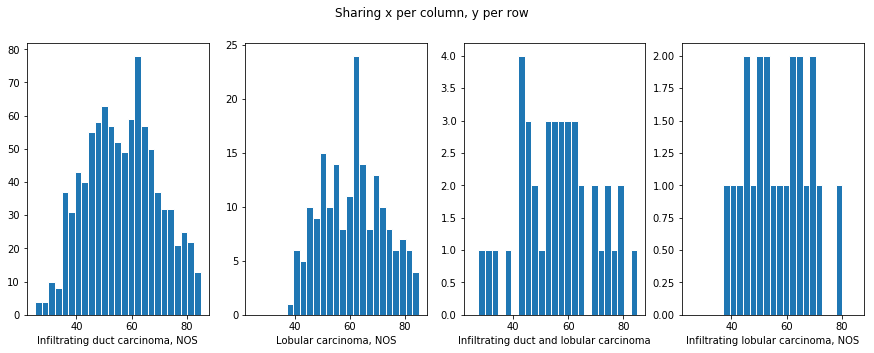

In [28]:
keys = ['Infiltrating duct carcinoma, NOS', 'Lobular carcinoma, NOS', 'Infiltrating duct and lobular carcinoma','Infiltrating lobular carcinoma, NOS']

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Sharing x per column, y per row')
for index, key in enumerate(keys):
    x = array_plot[key]["diagnoses.0.age_at_diagnosis"]/365
    axes[index].hist(x,range = (25, 85), bins = 25, color = 'tab:blue', edgecolor = 'white')
    #axes[index].title('Age at diagnosis')
    axes[index].set(xlabel= key)
    

In [63]:
age_and_mortality_rate_per_subtype=[]
for index, key in enumerate(keys):
    mortality = array_plot[key]["diagnoses.0.age_at_diagnosis"].mean()/365
    death_rate = array_plot[key][['case_id','demographic.vital_status']].groupby("demographic.vital_status").count()    
    if len(death_rate[death_rate.index == 'Alive'].index)>0:
        death_rate = int(death_rate[death_rate.index == 'Alive']['case_id']) / death_rate["case_id"].sum()
        age_and_mortality_rate_per_subtype.append([key, mortality, death_rate])

print(age_and_mortality_rate_per_subtype)

[['Infiltrating duct carcinoma, NOS', 57.11421466457762, 0.6970954356846473], ['Lobular carcinoma, NOS', 62.12580488144079, 0.8805970149253731], ['Infiltrating duct and lobular carcinoma', 56.32431506849315, 0.6]]


In [64]:
array_plot[key]["demographic.vital_status"].unique()
df["demographic.vital_status"].unique()
array_plot['Infiltrating duct carcinoma, NOS'][['case_id','demographic.vital_status']].groupby("demographic.vital_status").count()

array_plot[key][['case_id','demographic.vital_status']].groupby("demographic.vital_status").count()

,case_id
demographic.vital_status,
Not Reported,23



## Genomic Data :

50 most mutated genes
  General number of mutations for each histological subtypes
  Are the three most mutated genes known for being involved with each cancer ? 
  Is the presence of these mutations correlated with bad survival ?
Let's be a little bit more precise : many types of mutations

    SSM
      Types of SSM → Explication Louis. pie chart by histo types ?
      frequency of SSM (by histological type ?)
      People with more than one SSM in the same gene → we’ll have to deal with that.
      Other ?
    CNV
      Types of CNV → Explication Louis. Pie chart by histo types ?
      frequency of CNV (by histological type ?)
      Comparison SSM/CNV
      
Within the mutations : compare top 3 for CNV (in frequency) vs top 3 for SSM → is there a difference ? is it known ? (biblio check Louis)

As we explained in the scientifical background → the impact of genetic mutations on cancer biology mostly depends on protein modification. Having information on the amount of RNA should give additional information (especially in the case of CNV -> is an increase in the number of copies associated with an increase in the number of transcripts?)



## Transcriptomic Data

for how many people did we get the transcriptomic data ?
Correlation (Heatmap) for CNV gain/loss and increase/loss number of transcript for these genes. 
→ focus on HER2 : (HER2 amplification is super important in breast cancer treatment → Target chimio if amplified)
correlation for each histological subtype.
Difference in terms of survival (how to plot that precisely ?




# Submission

Travail de prédiction :

## Best objective : Prediction of the most effective treatment in patients with breast cancer
## Side objective : Histological category prediction
## Side objective : Survival prediction